In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
import sys
sys.path.append('../code/')

from common import APPLIANCES_ORDER, contri
from plot_functions import latexify, format_axes

In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 366
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
o = pickle.load(open('../../create_dataset/metadata/daily.pkl','r'))

In [6]:
df = o[2015]['Austin']
df = df.rename(columns={'num_occupants':'total_occupants',
                       "house_num_rooms":"num_rooms"})

In [7]:
def get_tensor_daily(df, dfc):
    start, stop = 1, 366
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [8]:
df = df
dfc = df.copy()
tensor = get_tensor_daily(df, dfc)


In [9]:
tensor.shape

(587, 7, 365)

In [10]:
source_static = np.ones((tensor.shape[0], 1))
static = np.r_[source_static]
L = get_L(static)
a = 2
b = 3

In [11]:
tensor.shape

(587, 7, 365)

In [12]:
def learn_HAT_adagrad_graph(case, tensor, L, num_home_factors, num_season_factors, num_iter=2000, lr=0.01, dis=False,
                            lam=1, random_seed=0, eps=1e-8, A_known = None, T_known = None):
    np.random.seed(random_seed)
    cost = cost_graph_laplacian
    
    args_num=[0,1,2]
    mg = multigrad(cost, argnums=args_num)

    params = {}
    params['M'], params['N'], params['O'] = tensor.shape
    params['a'] = num_home_factors
    params['b'] = num_season_factors
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)

    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    if A_known is not None:
        A = set_known(A, A_known)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_T = np.zeros_like(T)
    

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, L, tensor, lam, case)
        
        sum_square_gradients_A += eps + np.square(del_a)
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        A -= lr_a * del_a
        
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_T += eps + np.square(del_t)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        T -= lr_t * del_t

        if T_known is not None:
            T = set_known(T, T_known)
        if A_known is not None:
            A = set_known(A, A_known)

        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

      
        
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, L, tensor, lam, case))
    
    HAT = multiply_case(H, A, T, case)
    
    return H, A, T, HAT

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
pred = {}
for appliance in APPLIANCES_ORDER:
    pred[appliance] = []
for train, test in kf.split(df):
    print "*"*20
    train_index = df.index[train]
    test_index = df.index[test]
    test_train_index = np.hstack([test_index, train_index])
    df_t = df.loc[test_train_index]
    tensor = get_tensor(df_t, df_t.copy())
    tensor_copy = tensor.copy()
    # First n
    tensor_copy[:len(test), 1:, :] = np.NaN
    H, A, T, HAT = learn_HAT_adagrad_graph(2, tensor,
                                                            L,
                                                          a,
                                                          b,
                                                          num_iter=1000,
                                                          lr=1, dis=True,
                                                          lam=0,
                                                        )
    for appliance in APPLIANCES_ORDER:
        pred[appliance].append(pd.DataFrame(HAT[:len(test), appliance_index[appliance], :], index=test_index))

********************
19453.1514951
5681.27815767
********************
19452.9865268
5657.28477707


KeyboardInterrupt: 

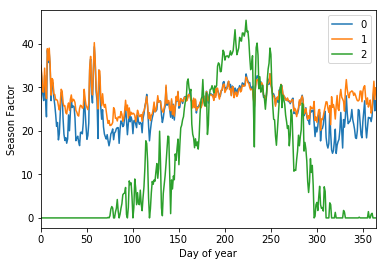

In [41]:
pd.DataFrame(T).plot()
plt.xlabel("Day of year")
plt.ylabel("Season Factor")

In [20]:
temp_data = pd.read_csv("/Users/nipunbatra/Downloads/1123068.csv")

In [22]:
temp_data.index = pd.DatetimeIndex(temp_data.DATE)

In [28]:
t = temp_data['TAVG'].dropna()

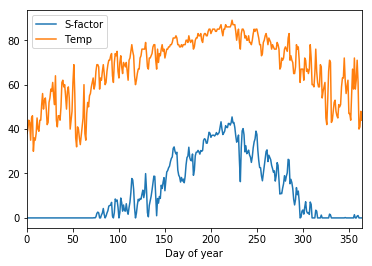

In [42]:
pd.DataFrame({"S-factor":T[:, 2], "Temp":t.values}).plot()
plt.xlabel("Day of year")


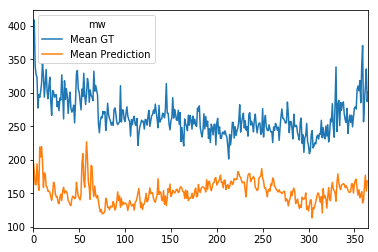

In [108]:
appliance="mw"
d = df[['%s_%d' %(appliance, day) for day in range(1, 366)]].mean()
d.index = range(1, 366)
ax = d.plot(label = "Mean GT")
#pd.DataFrame(np.einsum('mk, tk -> mt', A[2], T)).T.plot(kind='area', ax=ax)
pd.concat(pred[appliance]).mean().plot(ax=ax, label="Mean Prediction")
plt.legend(title=appliance)

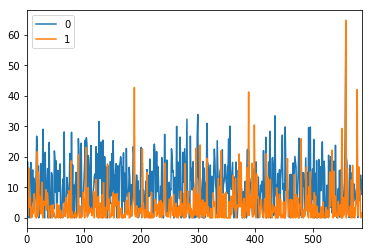

In [40]:
hf = pd.DataFrame(H)
hf['Area'] = 

In [15]:
for appliance in APPLIANCES_ORDER:
    pred[appliance] = pd.DataFrame(pd.concat(pred[appliance]))

In [16]:
from sklearn.metrics import mean_squared_error
def compute_rmse_fraction(appliance, pred_df, region='Austin', start=1, stop=366, year=2015):
    appliance_df = df.copy()

    #if appliance == "hvac":
    #    start, stop = 150, 330

    pred_df = pred_df.copy()
    pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    gt_df = appliance_df[pred_df.columns].ix[pred_df.index]

    aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    rows, cols = np.where((aggregate_df < 100))
    for r, c in zip(rows, cols):
        r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
        aggregate_df.loc[r_i, c_i] = np.NaN

    gt_fraction = gt_df.div(aggregate_df) * 100
    pred_fraction = pred_df.div(aggregate_df) * 100

    # Capping it to 100%
    pred_fraction[pred_fraction > 100] = 100.

    gt_fraction_dropna = gt_fraction.unstack().dropna()
    pred_fraction_dropna = pred_fraction.unstack().dropna()
    index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
    gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
    pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
    difference_error = (gt_fraction_dropna - pred_fraction_dropna).abs()

    rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
    return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error

In [17]:
o = {}
for appliance in APPLIANCES_ORDER[1:]:
    o[appliance] = compute_rmse_fraction(appliance, pred[appliance], "Austin")[2]


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/nipunbatra/anaconda2/lib/py

In [18]:
pd.Series(o)

dw         2.514794
fridge     6.624545
hvac      15.810310
mw         2.263829
oven       3.236161
wm         1.673978
dtype: float64

In [19]:
(pd.Series(contri['Austin'])*pd.Series(o)).sum()

13.285313255415762

In [31]:
tensor.shape

(587, 7, 365)

In [36]:
pred['aggregate'].loc[22].head()

0    13140.422988
1    12083.173699
2    10822.073534
3    10512.547735
4    12642.658954
Name: 22, dtype: float64

In [70]:
df.head(20)

,hvac_1,hvac_2,hvac_3,hvac_4,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,...,dr_364,dr_365,num_rooms,area,num_bedrooms,num_floors,area_first,area_second,area_third,total_occupants
22,4405.033203,9587.333008,5755.916504,2487.399902,9356.966797,4710.166504,1920.933350,11094.299805,10161.349609,11921.866211,...,NaN,NaN,NaN,816.0,NaN,NaN,NaN,NaN,NaN,NaN
26,6.533333,2.283333,0.883333,0.000000,0.950000,1.783333,1.300000,1.966667,0.616667,3.450000,...,NaN,NaN,6.0,2047.0,NaN,1.0,2075.0,0.0,0.0,4.0
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,606.0,NaN,NaN,NaN,NaN,NaN,NaN
59,37135.082031,37209.785156,31760.000000,27303.449219,42256.066406,29729.783203,20531.382812,55879.218750,48825.082031,48036.265625,...,3000.416748,1698.433350,11.0,3600.0,NaN,2.0,2705.0,1120.0,NaN,7.0
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,975.0,NaN,NaN,NaN,NaN,NaN,NaN
77,43706.367188,37362.300781,29753.433594,25791.550781,36680.949219,21706.699219,20766.933594,55844.832031,49288.683594,52577.968750,...,NaN,NaN,NaN,2669.0,NaN,NaN,1455.0,1214.0,NaN,NaN
86,1.000000,10.716666,20.366667,22.566668,9.216666,14.800000,8.050000,19.033333,2.950000,0.466667,...,1.733333,1.733333,NaN,1788.0,3.0,NaN,1788.0,0.0,0.0,NaN
93,1013.299988,959.933350,869.916687,934.400024,924.166626,942.583313,940.816650,966.866699,976.599976,972.283325,...,0.000000,0.000000,NaN,2934.0,4.0,NaN,2934.0,0.0,0.0,2.0
94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.733333,439.166687,3.0,1713.0,3.0,1.0,1713.0,0.0,0.0,2.0
101,2.133333,1.516667,0.900000,3.950000,8.866667,0.933333,1.783333,0.783333,0.783333,0.533333,...,14530.349609,2528.399902,5.0,1300.0,NaN,2.0,602.0,857.0,0.0,3.0


In [37]:
pd.DataFrame(tensor[0, 0, :]).head()

,0
0,18760.183594
1,22837.183594
2,17751.599609
3,14623.750000
4,17102.599609


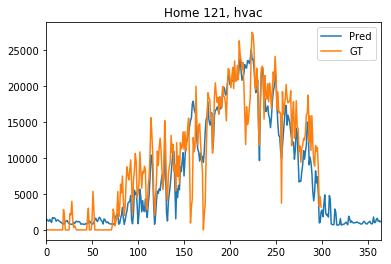

In [82]:
appliance="hvac"
home = 121
pred_appliance = pred[appliance].loc[home].squeeze()
ax = pred_appliance.plot(label='Pred')
gt = df[['%s_%d' %(appliance, day) for day in range(1, 366)]].loc[home]
gt.index = pred_appliance.index
gt.squeeze().plot(ax = ax, label='GT')
plt.title("Home %d, %s" %(home, appliance))
plt.legend()

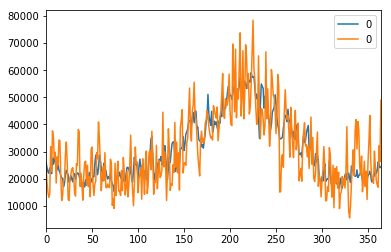

In [28]:
ax = pd.DataFrame(HATs[-1][10, 0, :]).plot()
pd.DataFrame(tensor[10, 0, :]).plot(ax=ax)

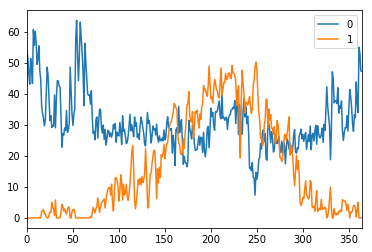

In [23]:
pd.DataFrame(T_agg).plot()